In [2]:
import os
import torch
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tensorflow as tf 
import numpy as np
import random
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import confusion_matrix

In [3]:

class SubMNIST(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.__load_data(self.root)
        if self.transform:
            self.data = self.transform(self.data)
        if self.target_transform:
            self.label = self.target_transform(self.label)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
        
    def __load_data(self, root):
        tree = os.walk(root)
        next(tree)
        self.data, self.label = [], []
        for dirpath, dirnames, filenames in tree:
            os.chdir(dirpath)
            self.data += [read_image(filename)/255 for filename in filenames]
            self.label += [int(os.path.relpath(dirpath, root))] * len(filenames)

In [4]:
!curl -L 'https://cloud.iitmandi.ac.in/d/955f1bc00ba146d2bcdf/files/?p=%2FGroup_8.zip&dl=1' -o Group_8.zip
!unzip Group_8.zip

Streaming output truncated to the last 5000 lines.
  inflating: Group_8/train/3/img_18023.jpg  
  inflating: Group_8/train/3/img_39848.jpg  
  inflating: Group_8/train/3/img_39156.jpg  
  inflating: Group_8/train/3/img_33974.jpg  
  inflating: Group_8/train/3/img_3329.jpg  
  inflating: Group_8/train/3/img_27864.jpg  
  inflating: Group_8/train/3/img_2671.jpg  
  inflating: Group_8/train/3/img_3979.jpg  
  inflating: Group_8/train/3/img_27886.jpg  
  inflating: Group_8/train/3/img_5890.jpg  
  inflating: Group_8/train/3/img_3349.jpg  
  inflating: Group_8/train/3/img_10829.jpg  
  inflating: Group_8/train/3/img_31532.jpg  
  inflating: Group_8/train/3/img_10652.jpg  
  inflating: Group_8/train/3/img_12190.jpg  
  inflating: Group_8/train/3/img_38144.jpg  
  inflating: Group_8/train/3/img_28793.jpg  
  inflating: Group_8/train/3/img_40896.jpg  
  inflating: Group_8/train/3/img_40281.jpg  
  inflating: Group_8/train/3/img_14756.jpg  
  inflating: Group_8/train/3/img_32491.jpg  
  inflati

In [5]:
training_data = SubMNIST(
    '/content/Group_8/train'
)
validation_data = SubMNIST(
    '/content/Group_8/val'
)
test_data = SubMNIST(
    '/content/Group_8/test'
)

In [6]:
LEN_TRAIN = len(training_data.data)
LEN_VAL = len(validation_data.data)
LEN_TEST = len(test_data.data)
X_train = np.array([x.numpy() for x in training_data.data]).reshape(LEN_TRAIN,28,28)
Y_train = np.array(training_data.label)

X_val = np.array([x.numpy() for x in validation_data.data]).reshape(LEN_VAL,28,28)
Y_val = np.array(validation_data.label)

X_test = np.array([x.numpy() for x in test_data.data]).reshape(LEN_TEST,28,28)
Y_test = np.array(test_data.label)

In [7]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#Utility functions 

#Implmented_callback to stop training when difference between successive Epochs fall below 1e-4. 
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1,min_delta=0.0001)

#To Plot the first 10 Images
def plot_graph(input,output,msg1,msg2):
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display orginal
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input[i].reshape(28,28))
    plt.title(msg1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display decoded
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i])
    plt.title(msg2)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

#To Plot Error graph based on the History recorded during training
def graph_plot(history,metric1,metric2,label1,label2,title,ylabel,xlabel):
  plt.plot(history.history[metric1], label=label1)
  plt.plot(history.history[metric2], label=label2)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.legend()
  plt.show()

def shuffle(X, Y):
  random_indices = np.random.permutation(X.shape[0])
  return X[random_indices], Y[random_indices]


In [8]:
random_indices = np.random.permutation(X_train.shape[0])

X_train, Y_train = shuffle(X_train, Y_train)
X_val, Y_val = shuffle(X_val,Y_val)
X_test, Y_test = shuffle(X_test, Y_test)

X_train = tf.convert_to_tensor(X_train, np.float32)
Y_train = tf.convert_to_tensor(Y_train, np.float32)

X_val = tf.convert_to_tensor(X_val, np.float32)
Y_val = tf.convert_to_tensor(Y_val, np.float32)

X_test = tf.convert_to_tensor(X_test, np.float32)
Y_test = tf.convert_to_tensor(Y_test, np.float32)

# 1-Layered AutoEncoder

In [9]:
#1 layer AutoEncoder
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='sigmoid'),  
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

single_auto = Autoencoder(latent_dim)

In [10]:
single_auto.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = single_auto.fit(X_train, X_train,
                callbacks=[my_callback],
                epochs=100,
                validation_data=(X_val, X_val))

Epoch 1/100
356/356 [==============================] - 2s 4ms/step - loss: 0.0661 - val_loss: 0.0579
Epoch 2/100
356/356 [==============================] - 2s 5ms/step - loss: 0.0537 - val_loss: 0.0495
Epoch 3/100
356/356 [==============================] - 1s 3ms/step - loss: 0.0443 - val_loss: 0.0409
Epoch 4/100
356/356 [==============================] - 1s 4ms/step - loss: 0.0378 - val_loss: 0.0357
Epoch 5/100
356/356 [==============================] - 1s 3ms/step - loss: 0.0333 - val_loss: 0.0320
Epoch 6/100
356/356 [==============================] - 1s 3ms/step - loss: 0.0301 - val_loss: 0.0292
Epoch 7/100
356/356 [==============================] - 1s 4ms/step - loss: 0.0275 - val_loss: 0.0268
Epoch 8/100
356/356 [==============================] - 1s 3ms/step - loss: 0.0252 - val_loss: 0.0247
Epoch 9/100
356/356 [==============================] - 1s 3ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 10/100
356/356 [==============================] - 1s 4ms/step - loss: 0.0216 - val_lo

### PLOT : MSE ERROR

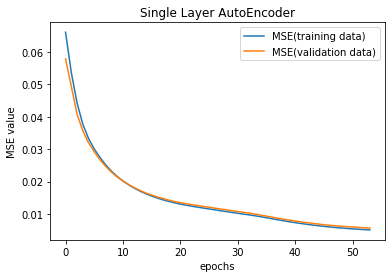

In [11]:
graph_plot(history,'loss','val_loss','MSE(training data)','MSE(validation data)','Single Layer AutoEncoder', 'MSE value','epochs')

### ORIGINAL VS RECONSTRUCTED

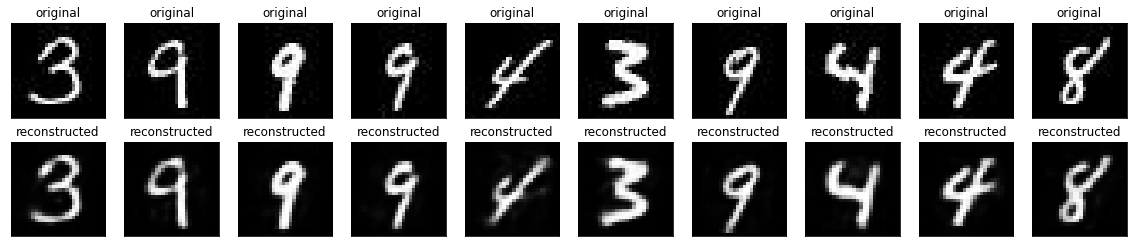

In [12]:
encoded_imgs = single_auto.encoder(X_test).numpy()
decoded_imgs = single_auto.decoder(encoded_imgs).numpy()
plot_graph(X_test,decoded_imgs,'original','reconstructed')

### TEST DATA LOSS

In [13]:
test_result = single_auto.evaluate(X_test,X_test)
print("Test Data loss is ",test_result)

119/119 [==============================] - 0s 2ms/step - loss: 0.0056
Test Data loss is  0.005556837189942598


### Weight Visualization

In [2]:
wts = np.array(single_auto.encoder.layers[1].weights[0]).reshape(28,28,latent_dim).T

fig = plt.figure(figsize=(500,500))
columns = 8
rows = 8
for i in range(1, latent_dim+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(wts[i-1])
plt.show()

NameError: ignored

## CLASSIFICATION

In [ ]:
single_classifier = tf.keras.models.Sequential([
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(64,activation='sigmoid'),
                        tf.keras.layers.Dense(10)
])

single_classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),       #losses obtained aren't normalizeed
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = single_classifier.fit(single_auto.encoder(X_train).numpy(), Y_train, epochs=80,callbacks = [my_callback],validation_data = (single_auto.encoder(X_val),Y_val))


### PLOT : TRAINING AND VAL ACCURACY

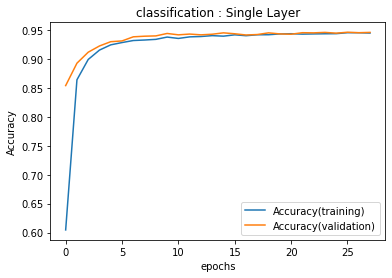

In [21]:
graph_plot(history,'sparse_categorical_accuracy','val_sparse_categorical_accuracy','Accuracy(training)', 'Accuracy(validation)', 'classification : Single Layer' ,'Accuracy', 'epochs')

### ACCURACIES

In [22]:
test_predict = single_classifier.evaluate(single_auto.encoder(X_test),Y_test)
val_predict = single_classifier.evaluate(single_auto.encoder(X_val),Y_val)
print(f"\nTest Data loss is {test_predict[0]} and accuracy is {test_predict[1]*100}% ")
print(f"\nVal Data loss is {val_predict[0]} and accuracy is {val_predict[1]*100}% ")

119/119 [==============================] - 0s 1ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.9460

Test Data loss is 0.1656729280948639 and accuracy is 93.9920961856842% 

Val Data loss is 0.16389808058738708 and accuracy is 94.59815621376038% 


### CONFUSION MATRIX

In [37]:
train_predict = tf.argmax(single_classifier.predict(single_auto.encoder(X_train)), axis = 1)
val_predict = tf.argmax(single_classifier.predict(single_auto.encoder(X_val)), axis = 1)

test_predict = tf.argmax(single_classifier.predict(single_auto.encoder(X_test)), axis = 1)

print("\n-------------------TRAIN CONFUSION MATRIX----------------------\n")
print(confusion_matrix(Y_train,train_predict))
print("\n-------------------VAL CONFUSION MATRIX----------------------\n")
print(confusion_matrix(Y_val,val_predict))
print("\n-------------------TEST CONFUSION MATRIX----------------------\n")
print(confusion_matrix(Y_test,test_predict))


-------------------TRAIN CONFUSION MATRIX----------------------

[[2237   15    1   19    5]
 [  19 2153    5   67   33]
 [  17    6 2113   15  126]
 [  48   83   11 2110   25]
 [   6   51   54   22 2144]]

-------------------VAL CONFUSION MATRIX----------------------

[[746   2   1   8   2]
 [  8 712   6  23  10]
 [  5   0 723   3  28]
 [ 11  29  10 701   8]
 [  4  14  22  11 708]]

-------------------TEST CONFUSION MATRIX----------------------

[[745   5   0   9   0]
 [  7 711   6  28   7]
 [  2   2 706   5  44]
 [ 15  33   8 691  12]
 [  7  11  15  12 714]]


# DENOISING AUTOENCODER

### 20% NOISE

In [18]:
noise_factor = 0.2
X_train_noisy = X_train + (noise_factor*tf.random.normal(shape=X_train.shape))
X_val_noisy = X_val + (noise_factor*tf.random.normal(shape=X_val.shape))
X_test_noisy = X_test + (noise_factor*tf.random.normal(shape=X_test.shape))


X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min = 0, clip_value_max = 1)
X_val_noisy = tf.clip_by_value(X_val_noisy, clip_value_min = 0, clip_value_max = 1)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min = 0, clip_value_max = 1)



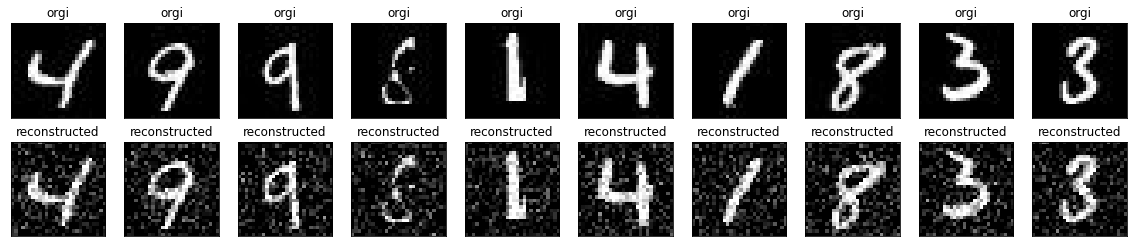

In [19]:
plot_graph(X_test, X_test_noisy,'orgi','reconstructed')

In [41]:
latent_dim = 64
noise_factor = 0.2

In [42]:
#1 layer AutoEncoder

class denoising_autoencoder(Model):
  def __init__(self, latent_dim):
    super(denoising_autoencoder, self).__init__()
    self.latent_dim = latent_dim  
    self.noise_factor = noise_factor 
    self.encoder = tf.keras.Sequential([
      layers.GaussianNoise(noise_factor),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='sigmoid'),  
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

single_noisy_auto = denoising_autoencoder(latent_dim)

In [43]:
single_noisy_auto.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = single_noisy_auto.fit(X_train, X_train,
                callbacks=[my_callback],
                epochs=100,
                validation_data=(X_val, X_val))

Epoch 1/100
356/356 [==============================] - 2s 5ms/step - loss: 0.0662 - val_loss: 0.0580
Epoch 2/100
356/356 [==============================] - 2s 5ms/step - loss: 0.0537 - val_loss: 0.0491
Epoch 3/100
356/356 [==============================] - 2s 4ms/step - loss: 0.0444 - val_loss: 0.0411
Epoch 4/100
356/356 [==============================] - 2s 4ms/step - loss: 0.0383 - val_loss: 0.0364
Epoch 5/100
356/356 [==============================] - 2s 4ms/step - loss: 0.0344 - val_loss: 0.0329
Epoch 6/100
356/356 [==============================] - 2s 4ms/step - loss: 0.0313 - val_loss: 0.0302
Epoch 7/100
356/356 [==============================] - 2s 5ms/step - loss: 0.0290 - val_loss: 0.0279
Epoch 8/100
356/356 [==============================] - 2s 5ms/step - loss: 0.0270 - val_loss: 0.0260
Epoch 9/100
356/356 [==============================] - 2s 4ms/step - loss: 0.0252 - val_loss: 0.0244
Epoch 10/100
356/356 [==============================] - 2s 4ms/step - loss: 0.0238 - val_lo

### PLOT : MSE

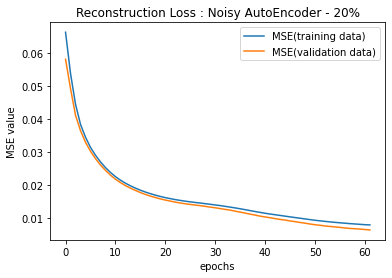

In [44]:
graph_plot(history,'loss','val_loss','MSE(training data)','MSE(validation data)','Reconstruction Loss : Noisy AutoEncoder - 20%', 'MSE value','epochs')

### ORIGINAL VS RECONSTRUCTED

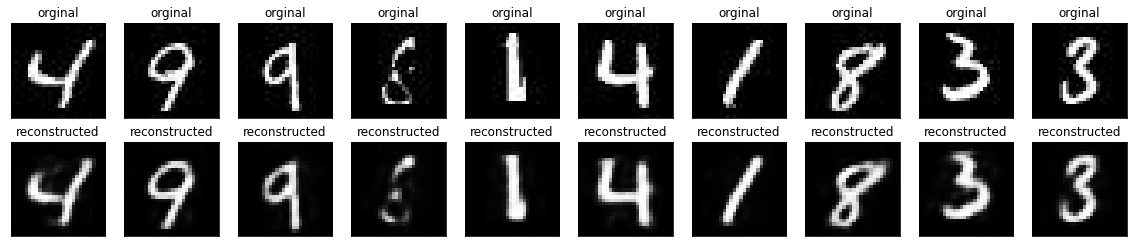

In [45]:
encoded_imgs = single_noisy_auto.encoder(X_test).numpy()
decoded_imgs = single_noisy_auto.decoder(encoded_imgs).numpy()
plot_graph(X_test,decoded_imgs,'orginal','reconstructed')

### WEIGHT VISUALIZATION

In [1]:
wts = np.array(single_noisy_auto.encoder.layers[2].weights[0]).reshape(28,28,latent_dim).T

fig = plt.figure(figsize=(500,500))
columns = 8
rows = 8
for i in range(1, latent_dim+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(wts[i-1])
plt.show()

NameError: ignored

### CLASSIFICATION WITH DENOISING AUTOENCODER

In [45]:
#Single layer classifier. 
single_noisy_classifier = tf.keras.models.Sequential([
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(64,activation='sigmoid'),
                        tf.keras.layers.Dense(10)
])

single_noisy_classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = single_noisy_classifier.fit(single_noisy_auto.encoder(X_train).numpy(), Y_train, epochs=80,callbacks = [my_callback],validation_data = (single_noisy_auto.encoder(X_val),Y_val))


Epoch 1/80
356/356 [==============================] - 2s 4ms/step - loss: 0.9175 - sparse_categorical_accuracy: 0.7961 - val_loss: 0.4203 - val_sparse_categorical_accuracy: 0.9217
Epoch 2/80
356/356 [==============================] - 1s 2ms/step - loss: 0.3257 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.2497 - val_sparse_categorical_accuracy: 0.9333
Epoch 3/80
356/356 [==============================] - 1s 2ms/step - loss: 0.2365 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.1978 - val_sparse_categorical_accuracy: 0.9391
Epoch 4/80
356/356 [==============================] - 1s 2ms/step - loss: 0.2058 - sparse_categorical_accuracy: 0.9368 - val_loss: 0.1780 - val_sparse_categorical_accuracy: 0.9415
Epoch 5/80
356/356 [==============================] - 1s 2ms/step - loss: 0.1892 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.1728 - val_sparse_categorical_accuracy: 0.9439
Epoch 6/80
356/356 [==============================] - 1s 2ms/step - loss: 0.1780 - sparse_categorica

### PLOT : ACCURACY

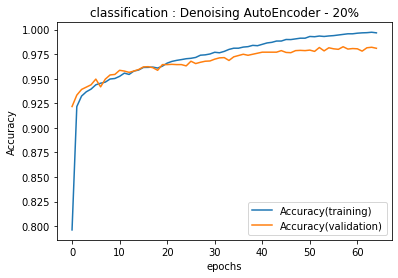

In [46]:
plot_Error(history,'sparse_categorical_accuracy','val_sparse_categorical_accuracy','Accuracy(training)', 'Accuracy(validation)', 'classification : Denoising AutoEncoder - 20%' ,'Accuracy', 'epochs')


### ACCURACIES

In [47]:
test_predict = single_noisy_classifier.evaluate(single_noisy_auto.encoder(X_test),Y_test)
val_predict = single_noisy_classifier.evaluate(single_noisy_auto.encoder(X_val),Y_val)
print(f"\nTest Data loss is {test_predict[0]} and accuracy is {test_predict[1]*100}% ")
print(f"\nVal Data loss is {val_predict[0]} and accuracy is {val_predict[1]*100}% ")

119/119 [==============================] - 0s 2ms/step - loss: 0.0577 - sparse_categorical_accuracy: 0.9810

Test Data loss is 0.0687638521194458 and accuracy is 98.07641506195068% 

Val Data loss is 0.057733260095119476 and accuracy is 98.10276627540588% 


## 40% DENOISING ENCODER

In [48]:
noise_factor = 0.4
X_train_noisy = X_train + (noise_factor*tf.random.normal(shape=X_train.shape))
X_val_noisy = X_val + (noise_factor*tf.random.normal(shape=X_val.shape))
X_test_noisy = X_test + (noise_factor*tf.random.normal(shape=X_test.shape))


X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min = 0, clip_value_max = 1)
X_val_noisy = tf.clip_by_value(X_val_noisy, clip_value_min = 0, clip_value_max = 1)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min = 0, clip_value_max = 1)


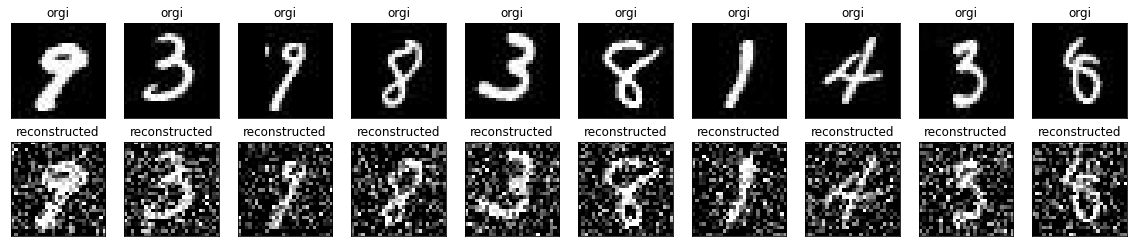

In [49]:
plot_graph(X_test, X_test_noisy,'orgi','reconstructed')


In [50]:
single_noisy_auto = denoising_autoencoder(latent_dim)

In [51]:
single_noisy_auto.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = single_noisy_auto.fit(X_train, X_train,
                callbacks=[my_callback],
                epochs=100,
                validation_data=(X_val, X_val))

Epoch 1/100
356/356 [==============================] - 3s 8ms/step - loss: 0.0511 - val_loss: 0.0357
Epoch 2/100
356/356 [==============================] - 3s 7ms/step - loss: 0.0311 - val_loss: 0.0258
Epoch 3/100
356/356 [==============================] - 2s 7ms/step - loss: 0.0242 - val_loss: 0.0201
Epoch 4/100
356/356 [==============================] - 3s 7ms/step - loss: 0.0203 - val_loss: 0.0165
Epoch 5/100
356/356 [==============================] - 3s 7ms/step - loss: 0.0178 - val_loss: 0.0141
Epoch 6/100
356/356 [==============================] - 2s 7ms/step - loss: 0.0161 - val_loss: 0.0124
Epoch 7/100
356/356 [==============================] - 3s 7ms/step - loss: 0.0150 - val_loss: 0.0111
Epoch 8/100
356/356 [==============================] - 2s 7ms/step - loss: 0.0141 - val_loss: 0.0101
Epoch 9/100
356/356 [==============================] - 3s 7ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 10/100
356/356 [==============================] - 2s 7ms/step - loss: 0.0129 - val_lo

### PLOT : MSE

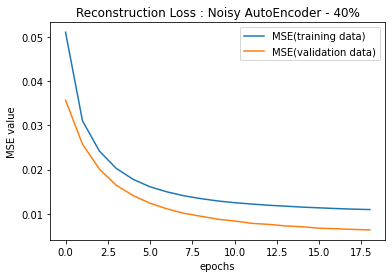

In [52]:
plot_Error(history,'loss','val_loss','MSE(training data)','MSE(validation data)','Reconstruction Loss : Noisy AutoEncoder - 40%', 'MSE value','epochs')

### ORIGINAL VS RECONSTRUCTED

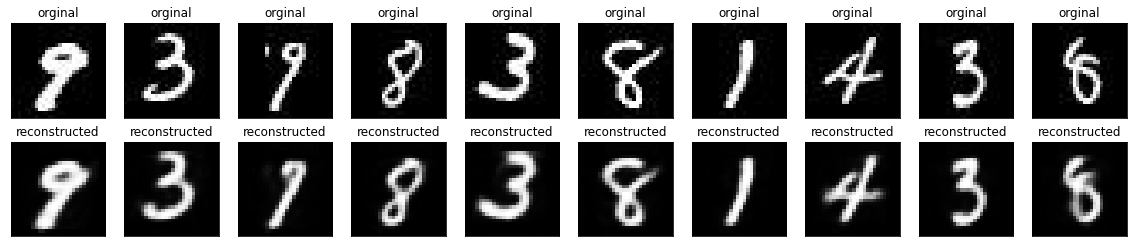

In [53]:
encoded_imgs = single_noisy_auto.encoder(X_test).numpy()
decoded_imgs = single_noisy_auto.decoder(encoded_imgs).numpy()
plot_graph(X_test,decoded_imgs,'orginal','reconstructed')

### CLASSIFICATION USING DENOISING AUTOENCODER - 40%

In [54]:
#Single layer classifier. 

single_noisy_classifier = tf.keras.models.Sequential([
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(64,activation='sigmoid'),
                        tf.keras.layers.Dense(10)
])

single_noisy_classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = single_noisy_classifier.fit(single_noisy_auto.encoder(X_train).numpy(), Y_train, epochs=80,callbacks = [my_callback],validation_data = (single_noisy_auto.encoder(X_val),Y_val))


Epoch 1/80
356/356 [==============================] - 2s 3ms/step - loss: 0.7870 - sparse_categorical_accuracy: 0.8241 - val_loss: 0.3417 - val_sparse_categorical_accuracy: 0.9212
Epoch 2/80
356/356 [==============================] - 1s 2ms/step - loss: 0.2777 - sparse_categorical_accuracy: 0.9261 - val_loss: 0.2161 - val_sparse_categorical_accuracy: 0.9352
Epoch 3/80
356/356 [==============================] - 1s 2ms/step - loss: 0.2144 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.1811 - val_sparse_categorical_accuracy: 0.9447
Epoch 4/80
356/356 [==============================] - 1s 3ms/step - loss: 0.1896 - sparse_categorical_accuracy: 0.9419 - val_loss: 0.1610 - val_sparse_categorical_accuracy: 0.9489
Epoch 5/80
356/356 [==============================] - 1s 4ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.9440 - val_loss: 0.1575 - val_sparse_categorical_accuracy: 0.9486
Epoch 6/80
356/356 [==============================] - 1s 3ms/step - loss: 0.1653 - sparse_categorica

### PLOT : ACCURACY

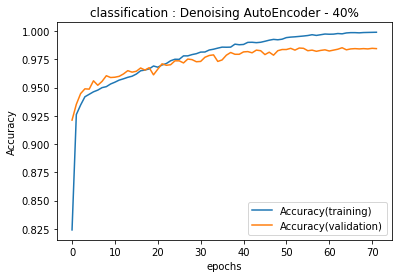

In [55]:
plot_Error(history,'sparse_categorical_accuracy','val_sparse_categorical_accuracy','Accuracy(training)', 'Accuracy(validation)', 'classification : Denoising AutoEncoder - 40%' ,'Accuracy', 'epochs')


### ACCURACIES

In [56]:
test_predict = single_noisy_classifier.evaluate(single_noisy_auto.encoder(X_test),Y_test)
val_predict = single_noisy_classifier.evaluate(single_noisy_auto.encoder(X_val),Y_val)
print(f"\nTest Data loss is {test_predict[0]} and accuracy is {test_predict[1]*100}% ")
print(f"\nVal Data loss is {val_predict[0]} and accuracy is {val_predict[1]*100}% ")

119/119 [==============================] - 0s 2ms/step - loss: 0.0557 - sparse_categorical_accuracy: 0.9845

Test Data loss is 0.060409896075725555 and accuracy is 98.28721880912781% 

Val Data loss is 0.055743250995874405 and accuracy is 98.44532012939453% 


# 3 Layered AUTOENCODER

In [ ]:
#3 layer AutoEncoder
latent_dim = 64
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256,activation='sigmoid'),
      layers.Dense(128,activation='sigmoid'),
      layers.Dense(latent_dim, activation='sigmoid'),   #change this to sigmoid
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(128,activation='sigmoid'),
      layers.Dense(256,activation='sigmoid'),
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

triple_auto = Autoencoder(latent_dim)

In [ ]:
triple_auto.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = triple_auto.fit(X_train, X_train,
                callbacks=[my_callback],
                epochs=100,
                validation_data=(X_test, X_test))

Epoch 1/100
356/356 [==============================] - 4s 9ms/step - loss: 0.0610 - val_loss: 0.0571
Epoch 2/100
356/356 [==============================] - 3s 8ms/step - loss: 0.0517 - val_loss: 0.0499
Epoch 3/100
356/356 [==============================] - 3s 9ms/step - loss: 0.0474 - val_loss: 0.0447
Epoch 4/100
356/356 [==============================] - 3s 10ms/step - loss: 0.0426 - val_loss: 0.0408
Epoch 5/100
356/356 [==============================] - 4s 11ms/step - loss: 0.0387 - val_loss: 0.0366
Epoch 6/100
356/356 [==============================] - 3s 8ms/step - loss: 0.0349 - val_loss: 0.0337
Epoch 7/100
356/356 [==============================] - 3s 8ms/step - loss: 0.0329 - val_loss: 0.0324
Epoch 8/100
356/356 [==============================] - 3s 8ms/step - loss: 0.0317 - val_loss: 0.0313
Epoch 9/100
356/356 [==============================] - 3s 9ms/step - loss: 0.0308 - val_loss: 0.0305
Epoch 10/100
356/356 [==============================] - 3s 8ms/step - loss: 0.0300 - val_

### PLOT : MSE ERROR

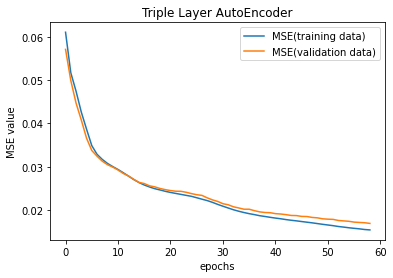

In [ ]:
plot_Error(history,'loss','val_loss','MSE(training data)','MSE(validation data)','Triple Layer AutoEncoder', 'MSE value','epochs')

### ORGINAL VS RECONSTRUCTED

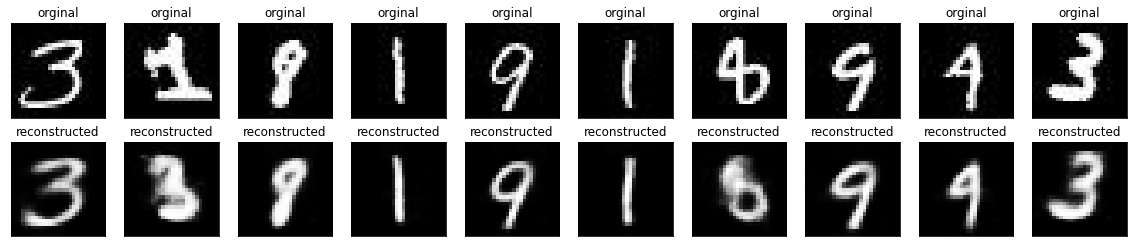

In [ ]:
encoded_imgs = triple_auto.encoder(X_test).numpy()
decoded_imgs = triple_auto.decoder(encoded_imgs).numpy()
plot_graph(X_test,decoded_imgs,'orginal','reconstructed')

### Evaluation on Test Data

In [ ]:
test_result = triple_auto.evaluate(X_test,X_test)
print("Test Data loss is ",test_result)

119/119 [==============================] - 0s 3ms/step - loss: 0.0169
Test Data loss is  0.016921326518058777


### CLASSIFICATION

In [ ]:
#triple layer classifier. 
triple_classifier = tf.keras.models.Sequential([
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(256,activation = 'sigmoid'),
                        tf.keras.layers.Dense(128,activation = 'sigmoid'),
                        tf.keras.layers.Dense(64,activation='sigmoid'),
                        tf.keras.layers.Dense(10)
])

triple_classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = triple_classifier.fit(triple_auto.encoder(X_train).numpy(), Y_train, epochs=80,callbacks = [my_callback],validation_data = (triple_auto.encoder(X_val),Y_val))


Epoch 1/80
356/356 [==============================] - 2s 4ms/step - loss: 0.9503 - sparse_categorical_accuracy: 0.6521 - val_loss: 0.3168 - val_sparse_categorical_accuracy: 0.9265
Epoch 2/80
356/356 [==============================] - 1s 4ms/step - loss: 0.2243 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.1875 - val_sparse_categorical_accuracy: 0.9426
Epoch 3/80
356/356 [==============================] - 1s 3ms/step - loss: 0.1824 - sparse_categorical_accuracy: 0.9448 - val_loss: 0.1811 - val_sparse_categorical_accuracy: 0.9412
Epoch 4/80
356/356 [==============================] - 1s 3ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.1683 - val_sparse_categorical_accuracy: 0.9494
Epoch 5/80
356/356 [==============================] - 1s 3ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.1721 - val_sparse_categorical_accuracy: 0.9497
Epoch 6/80
356/356 [==============================] - 1s 3ms/step - loss: 0.1638 - sparse_categorica

### PLOT : ACCURACY

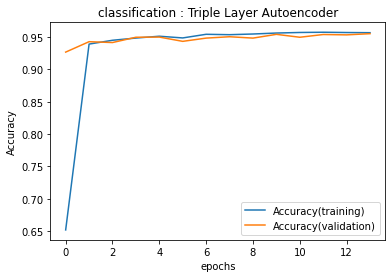

In [ ]:
plot_Error(history,'sparse_categorical_accuracy','val_sparse_categorical_accuracy','Accuracy(training)', 'Accuracy(validation)', 'classification : Triple Layer Autoencoder' ,'Accuracy', 'epochs')

### ACCURACIES

In [ ]:
#compare with test and validation accuracy 

test_predict = single_classifier.evaluate(single_auto.encoder(X_test),Y_test)
val_predict = single_classifier.evaluate(single_auto.encoder(X_val),Y_val)
print(f"\nTest Data loss is {test_predict[0]} and accuracy is {test_predict[1]*100}% ")
print(f"\nVal Data loss is {val_predict[0]} and accuracy is {val_predict[1]*100}% ")

119/119 [==============================] - 0s 1ms/step - loss: 0.1628 - sparse_categorical_accuracy: 0.9468

Test Data loss is 0.16160577535629272 and accuracy is 95.12516260147095% 

Val Data loss is 0.16279491782188416 and accuracy is 94.6772038936615% 
